In [1]:
from lcdb.db import LCDB
import pandas as pd
from lcdb.db._dataframe import deserialize_dataframe
from lcdb.analysis.json import QueryMetricValuesFromAnchors, QueryAnchorValues
from lcdb.analysis.score import balanced_accuracy_from_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from lcdb.db._util import print_tree
from lcdb.analysis.util import LearningCurveExtractor

import json
import pprint

In [4]:
datasets = [3]#, 6, 11, 12]
workflows = [
    "lcdb.workflow.sklearn.KNNWorkflow",
    "lcdb.workflow.sklearn.LibLinearWorkflow",
    "lcdb.workflow.sklearn.LibSVMWorkflow",
    "lcdb.workflow.sklearn.TreesEnsembleWorkflow"
]
#workflows = workflows[0:1]

lcdb = LCDB()
df_sample_wise_curves_per_workflow = {}

df = lcdb.query(
    openmlids=[6],
    workflows=workflows[-1],
    return_generator=False,
    processors={
        "learning_curve": LearningCurveExtractor(
            metrics=["error_rate"],
            folds=["train", "val", "test", "oob"]
        )
    },
    show_progress=True
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:25<00:00, 25.66s/it]


(1, 4, 1, 1, 1, 21, 11)


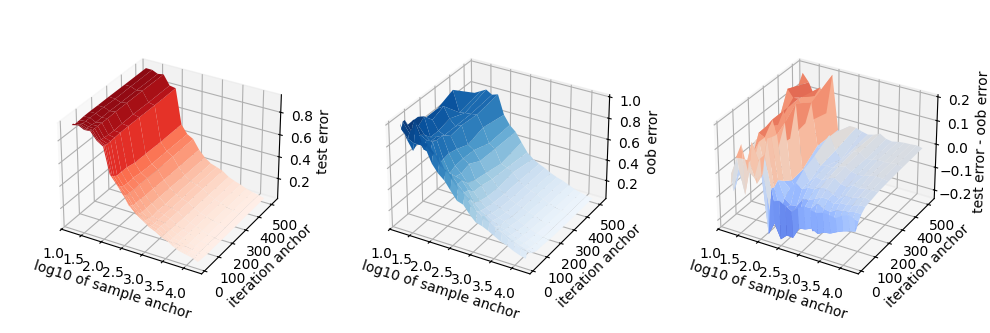

In [7]:
print(df["learning_curve"].iloc[0].values.shape)

lc = df["learning_curve"].iloc[0].values[0].mean(axis=(1,2,3))
lc_diff = lc[2] - lc[3]  # test - oob performance

fig, axs = plt.subplots(1, 3, figsize=(10, 4), subplot_kw={"projection": "3d"})

# Make data.
X = np.log10(np.array(df["learning_curve"].iloc[0].anchors_size))
Y = np.array(df["learning_curve"].iloc[0].anchors_iteration)
X, Y = np.meshgrid(X, Y)

for ax in axs:
    ax.set_xlabel("log10 of sample anchor")
    ax.set_ylabel("iteration anchor")

    ax.set_box_aspect(None, zoom=0.8)

# Plot the surfaces.
ax = axs[0]
surf = ax.plot_surface(X, Y, lc[2].T, cmap="Reds", vmin=0, vmax=1.0)
ax.set_zlabel("test error")

ax = axs[1]
surf = ax.plot_surface(X, Y, lc[3].T, cmap="Blues", vmin=0, vmax=1.0)
ax.set_zlabel("oob error")

ax = axs[2]
surf = ax.plot_surface(X, Y, lc_diff.T, cmap="coolwarm", vmin=-0.2, vmax=0.2)
ax.set_zlabel("test error - oob error")

# Adjust layout to avoid cutting off labels
fig.tight_layout()

fig.savefig("plots/oob_vs_test.pdf", bbox_inches="tight")
plt.show()